In [35]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
def show_tiff(tiff_path, cmap='terrain'):
    """Display a single TIFF in Jupyter"""
    with rasterio.open(tiff_path) as src:
        data = src.read(1).astype(float)
        if src.nodata is not None:
            data[data == src.nodata] = np.nan

        plt.figure(figsize=(10, 8))
        plt.imshow(data, cmap=cmap)
        plt.colorbar(label='Height (m)')
        plt.title(Path(tiff_path).stem)
        plt.axis('off')
        plt.show()

In [37]:
def inspect_tiff(tiff_path):
    """Comprehensive inspection of TIFF file contents"""

    print(f"🔍 INSPECTING: {Path(tiff_path).name}")
    print("="*60)

    with rasterio.open(tiff_path) as src:
        # Basic file info
        print(f"📋 BASIC INFO:")
        print(f"  Dimensions: {src.width} x {src.height}")
        print(f"  Bands: {src.count}")
        print(f"  Data types: {src.dtypes}")
        print(f"  CRS: {src.crs}")
        print(f"  Resolution: {src.res}")
        print(f"  Bounds: {src.bounds}")
        print(f"  NoData: {src.nodata}")

        # Metadata
        print(f"\n📝 METADATA:")
        if src.tags():
            for key, value in src.tags().items():
                print(f"  {key}: {value}")
        else:
            print("  No metadata found")

        # Band descriptions
        print(f"\n📊 BAND INFORMATION:")
        for i in range(1, src.count + 1):
            print(f"\n  BAND {i}:")

            # Band metadata
            band_tags = src.tags(i)
            if band_tags:
                for key, value in band_tags.items():
                    print(f"    {key}: {value}")

            # Read sample data
            data = src.read(i)

            # Handle nodata
            if src.nodata is not None:
                valid_data = data[data != src.nodata]
            else:
                valid_data = data.flatten()

            if len(valid_data) > 0:
                print(f"    Data type: {data.dtype}")
                print(f"    Valid pixels: {len(valid_data):,} / {data.size:,} ({len(valid_data)/data.size*100:.1f}%)")
                print(f"    Range: {valid_data.min():.3f} to {valid_data.max():.3f}")
                print(f"    Mean: {valid_data.mean():.3f}")
                print(f"    Std: {valid_data.std():.3f}")

                # Check for common LiDAR data patterns
                unique_vals = np.unique(valid_data)
                if len(unique_vals) < 20:
                    print(f"    Unique values: {unique_vals}")
                    print(f"    → Likely classification/categorical data")
                elif valid_data.max() < 100:
                    print(f"    → Possibly intensity, return info, or relative heights")
                elif 100 <= valid_data.max() < 5000:
                    print(f"    → Likely elevation data (meters)")
                else:
                    print(f"    → Possibly elevation in different units")
            else:
                print(f"    No valid data found")

        # Color interpretation (if available)
        print(f"\n🎨 COLOR INTERPRETATION:")
        for i in range(1, src.count + 1):
            color_interp = src.colorinterp[i-1]
            print(f"  Band {i}: {color_interp}")

        # Overviews
        print(f"\n🔍 OVERVIEWS:")
        for i in range(1, src.count + 1):
            overviews = src.overviews(i)
            if overviews:
                print(f"  Band {i}: {len(overviews)} overview levels")
            else:
                print(f"  Band {i}: No overviews")

In [38]:
# Simple DEM Comparison Analysis
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Additional analysis imports
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xarray as xr
DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

TARGET_CRS = 'EPSG:32632'  # UTM 32N
resolution = 10  # meters
NODATA = -9999
saocom_files = list(DATA_DIR.glob("verona*"))

In [39]:
"""Load SAOCOM point data"""
# Try different separators

df = pd.read_csv(saocom_files[0], sep=',')
# Standardize column names
cols = df.columns.str.upper().str.strip()
mapping = {'LAT': 'lat', 'LON': 'lon', 'HEIGHT': 'height', 'COHER': 'coherence'}

for old, new in mapping.items():
    if old in cols:
        df = df.rename(columns={old: new})

# Clean data
for col in ['lat', 'lon', 'height', 'coherence']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['lat', 'lon', 'height'])
df = df[df['coherence'] >= 0.3]  # Filter by coherence

# Convert to GeoDataFrame and reproject
geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
gdf = gdf.to_crs(TARGET_CRS)
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

In [40]:
"""Convert points to regular grid"""
method = 'cubic'
# Define grid bounds
bounds = gdf.total_bounds
xmin, ymin, xmax, ymax = bounds

# Create grid
x = np.arange(xmin, xmax + resolution, resolution)
y = np.arange(ymax, ymin - resolution, -resolution)  # Flip Y direction
grid_x, grid_y = np.meshgrid(x, y)

# Interpolate
points_xy = np.column_stack([gdf['x'], gdf['y']])
values = gdf['height'].values
grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

grid_values = griddata(points_xy, values, grid_points, method=method, fill_value=NODATA)
saocom_grid = grid_values.reshape(grid_x.shape)

# Save as GeoTIFF
transform = from_bounds(xmin, ymin, xmax, ymax, len(x), len(y))

saocom_raster_path = RESULTS_DIR / f"saocom_dem_{method}.tif"
with rasterio.open(saocom_raster_path, 'w', driver='GTiff', height=saocom_grid.shape[0],
                   width=saocom_grid.shape[1], count=1, dtype='float32',
                   crs=TARGET_CRS, transform=transform, nodata=NODATA) as dst:
    dst.write(saocom_grid.astype('float32'), 1)



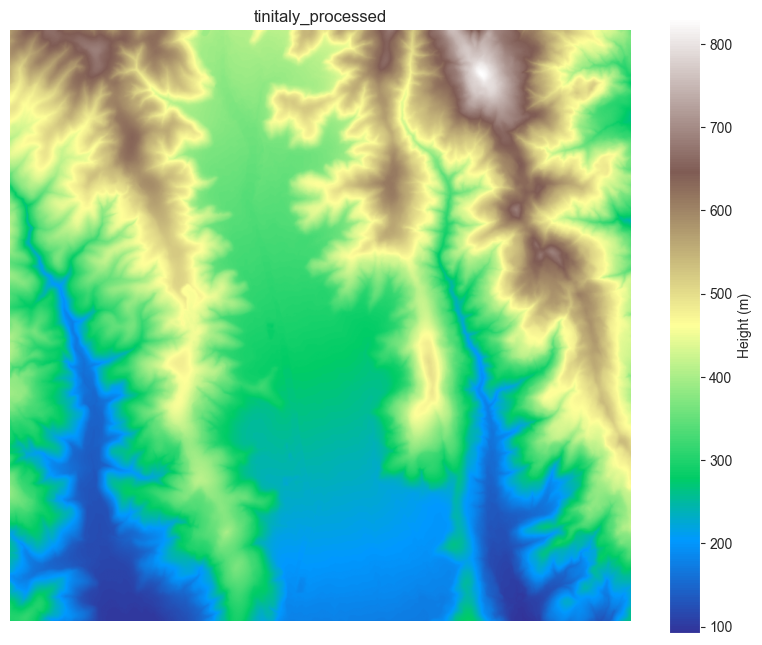

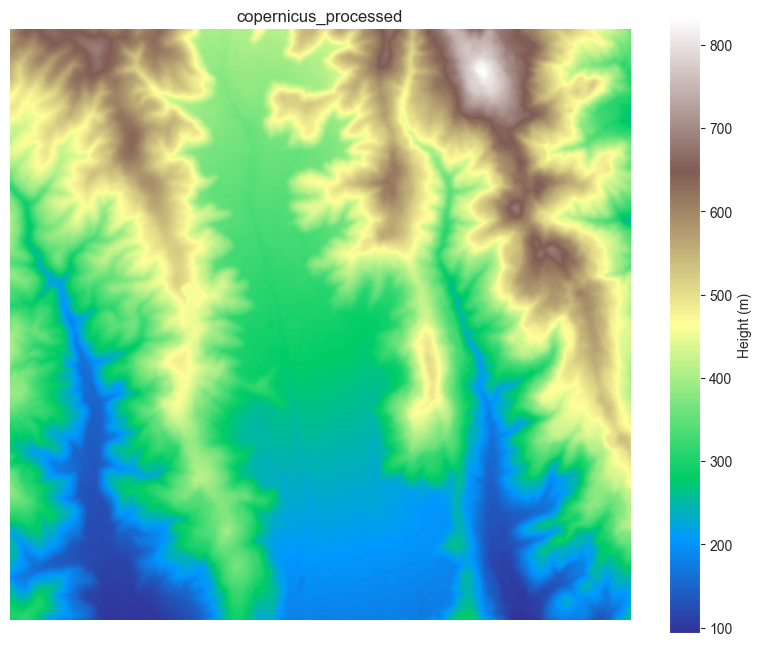

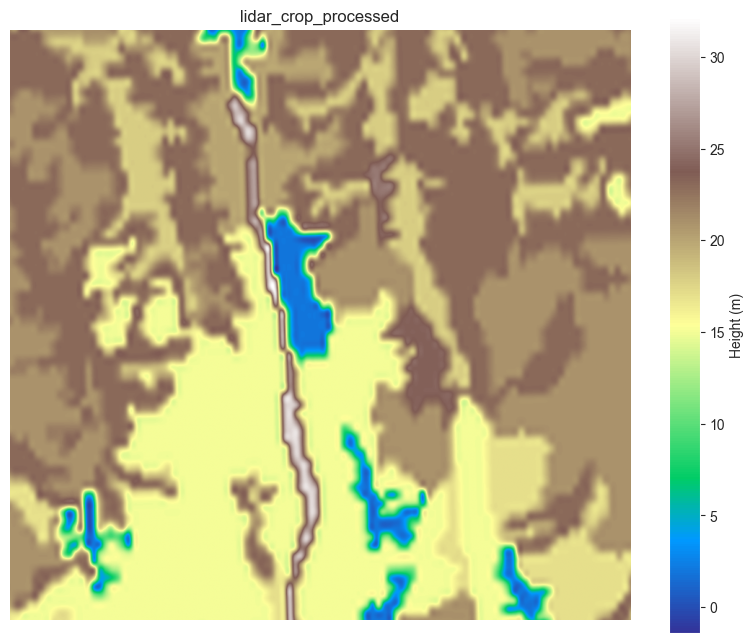

In [52]:
def process_reference_dem(dem_path, target_bounds, target_transform, target_width, target_height):
    """Reproject and resample DEM to target grid"""
    output_path = RESULTS_DIR / f"{dem_path.stem}_processed.tif"

    with rasterio.open(dem_path) as src:
        # Setup output profile
        profile = {
            'driver': 'GTiff',
            'dtype': 'float32',
            'width': target_width,
            'height': target_height,
            'count': 1,
            'crs': TARGET_CRS,
            'transform': target_transform,
            'nodata': NODATA
        }

        # Create output array
        output_array = np.full((target_height, target_width), NODATA, dtype=np.float32)

        # Reproject
        reproject(
            source=rasterio.band(src, 1),
            destination=output_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.cubic,
            src_nodata=src.nodata,
            dst_nodata=NODATA
        )
        # Check result
        valid_pixels = np.sum(output_array != NODATA)
        if valid_pixels > 0:
            valid_data = output_array[output_array != NODATA]

        # Save
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(output_array, 1)
        show_tiff(output_path)
    return output_path

reference_dems = {}
if 'saocom_grid' in locals():
    # Get target grid from SAOCOM
    bounds = [grid_x.min(), grid_y.min(), grid_x.max(), grid_y.max()]
    transform = from_bounds(*bounds, grid_x.shape[1], grid_x.shape[0])

    # Find and process reference DEMs
    dem_patterns = {
        'tinitaly': '*tinitaly*',
        'copernicus': '*GLO30*',
        'lidar_crop': '*lidar*'
    }

    for name, pattern in dem_patterns.items():
        dem_files = list(DATA_DIR.glob(f"{name}.tif")) + list(DATA_DIR.glob(f"{name}.TIF"))
        if dem_files:
            processed_path = process_reference_dem(
                dem_files[0], bounds, transform, grid_x.shape[1], grid_x.shape[0]
            )
            reference_dems[name] = processed_path
